In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('data.csv', encoding='ISO-8859-1')

In [3]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [5]:
# Standardize the column names: all lowercase, spaces replaced with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Display the standardized column names to confirm the changes
df.columns.tolist()

['row_id',
 'order_id',
 'order_date',
 'ship_date',
 'ship_mode',
 'customer_id',
 'customer_name',
 'segment',
 'country',
 'city',
 'state',
 'postal_code',
 'region',
 'product_id',
 'category',
 'sub-category',
 'product_name',
 'sales',
 'quantity',
 'discount',
 'profit']

In [6]:
# Convert 'order_date' and 'ship_date' to datetime format
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
df['ship_date'] = pd.to_datetime(df['ship_date'], errors='coerce')

In [7]:
# Check unique values in categorical columns for consistency
categorical_columns = ['ship_mode', 'segment', 'country', 'region', 'category', 'sub-category']
categorical_uniques = {column: df[column].unique() for column in categorical_columns}

In [8]:
# Statistical summary for numerical columns to identify potential outliers
numerical_summary = df.describe()

In [9]:
# Date Features Engineering
df['order_year'] = df['order_date'].dt.year
df['order_month'] = df['order_date'].dt.month
df['order_day'] = df['order_date'].dt.day
df['order_day_of_week'] = df['order_date'].dt.dayofweek
df['is_weekend'] = df['order_day_of_week'].isin([5, 6]).astype(int)
df['shipping_duration'] = (df['ship_date'] - df['order_date']).dt.days

In [11]:
df.drop('row_id', axis=1, inplace=True)
df.drop('order_id', axis=1, inplace=True)
df.drop('order_date', axis=1, inplace=True)
df.drop('ship_date', axis=1, inplace=True)
df.drop('customer_id', axis=1, inplace=True)
df.drop('customer_name', axis=1, inplace=True)
df.drop('country', axis=1, inplace=True)
df.drop('postal_code', axis=1, inplace=True)
df.drop('product_id', axis=1, inplace=True)

In [12]:
# Calculate unit price as sales divided by quantity
df['unit_price'] = df['sales'] / df['quantity']

# To illustrate the approach, let's take a look at the distribution of unit prices within a specific sub-category
# We'll choose a sub-category with a diverse range of products. For demonstration, let's use "Binders"
binders_unit_prices = df[df['sub-category'] == 'Binders']['unit_price']

# Display basic statistics to understand the distribution of unit prices within "Binders"
binders_unit_prices.describe()

count    1523.000000
mean       36.672279
std       141.421271
min         0.336000
25%         2.742000
50%         5.380000
75%        15.010000
max      1889.990000
Name: unit_price, dtype: float64

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np

def optimal_clusters(data, max_k=10):
    """
    Determine the optimal number of clusters using the Elbow Method and Silhouette Score.
    """
    scores = []
    silhouette_scores = []
    K_range = range(2, max_k + 1)
    cluster_centers = {}

    for K in K_range:
        kmeans = KMeans(n_clusters=K, random_state=42).fit(data)
        scores.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))

    # Silhouette Method: Find the number of clusters with the highest silhouette score
    best_silhouette_index = np.argmax(silhouette_scores)
    best_k = K_range[best_silhouette_index]
    best_kmeans = KMeans(n_clusters=best_k, random_state=42).fit(data)
    
    # Save the cluster centers for the best K
    cluster_centers['centers'] = best_kmeans.cluster_centers_
    cluster_centers['n_clusters'] = best_k

    return best_kmeans.labels_, cluster_centers

# Initialize a dictionary to store cluster centers for each sub-category
sub_category_cluster_centers = {}

# Assuming 'df' is your DataFrame
clustered_data = pd.DataFrame()
for sub_category in df['sub-category'].unique():
    sub_category_data = df[df['sub-category'] == sub_category].copy()
    prices = sub_category_data[['unit_price']]

    if len(prices) > 1:  # Ensure there's enough data for clustering
        labels, centers = optimal_clusters(prices)
        sub_category_data['price_cluster'] = labels
        sub_category_cluster_centers[sub_category] = centers
    else:
        sub_category_data['price_cluster'] = 0  # Assign to a single cluster if not enough data

    clustered_data = pd.concat([clustered_data, sub_category_data])

# 'clustered_data' now includes the 'price_cluster' column, and 'sub_category_cluster_centers' stores the cluster centers for each sub-category.


c:\Users\farha\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\farha\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\farha\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\farha\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  

In [16]:
# Adjust cluster labels to be distinct across different sub-categories
clustered_data['distinct_cluster_label'] = clustered_data['sub-category'] + '_' + clustered_data['price_cluster'].astype(str)

In [28]:
clustered_data.distinct_cluster_label.nunique()

38

In [19]:
clustered_data.drop('product_name', axis=1, inplace=True)

In [24]:
import pandas as pd
import phik

# phik correlation
phik_matrix = clustered_data.phik_matrix()

interval columns not set, guessing: ['sales', 'quantity', 'discount', 'profit', 'order_year', 'order_month', 'order_day', 'order_day_of_week', 'is_weekend', 'shipping_duration', 'unit_price', 'price_cluster']


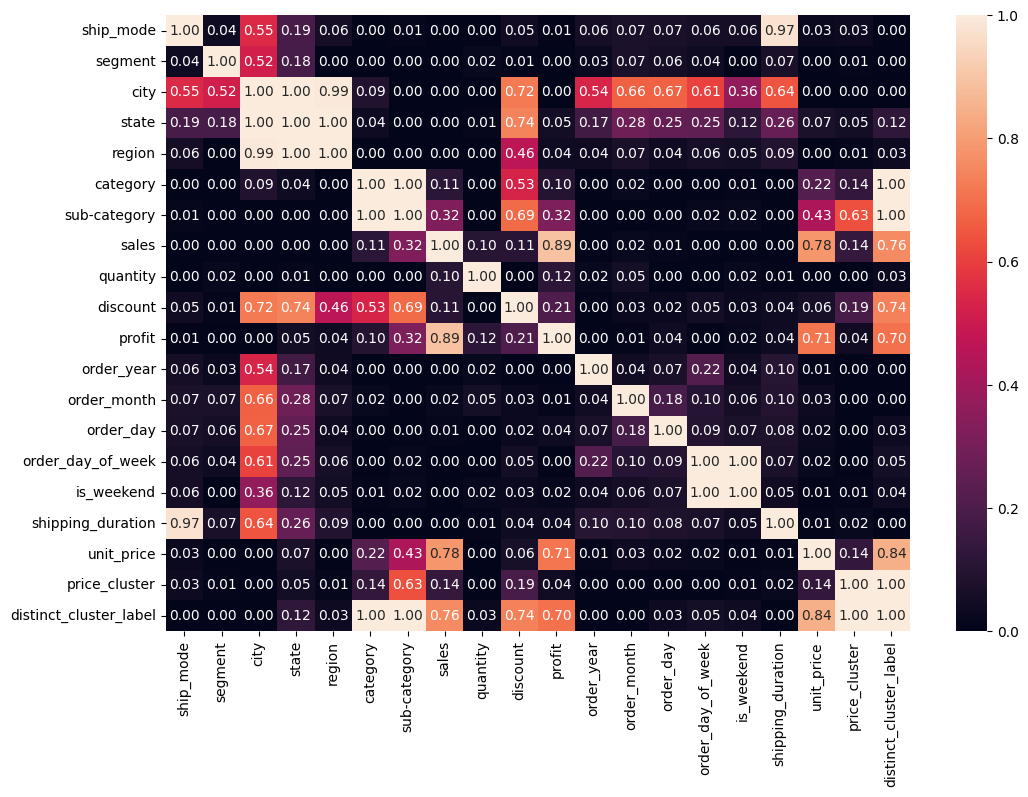

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(phik_matrix, annot=True, fmt=".2f")
plt.show()

In [27]:
# Isolate the correlation with profit
correlation_with_profit_phik = phik_matrix['profit'].sort_values(ascending=False)
print(correlation_with_profit_phik)

profit                    1.000000
sales                     0.893351
unit_price                0.714247
distinct_cluster_label    0.699394
sub-category              0.319992
discount                  0.206762
quantity                  0.115840
category                  0.095263
state                     0.050452
price_cluster             0.044965
order_day                 0.038294
shipping_duration         0.037399
region                    0.035284
is_weekend                0.018712
order_month               0.008245
ship_mode                 0.007790
segment                   0.000000
order_year                0.000000
order_day_of_week         0.000000
city                      0.000000
Name: profit, dtype: float64


In [29]:
from sklearn.model_selection import train_test_split

# Selecting features
features = ['sales', 'unit_price', 'discount', 'quantity', 'distinct_cluster_label', 'sub-category']

# Target variable
target = 'profit'

# Splitting data into 70% train and 30% combined validation and test
X_train, X_temp, y_train, y_temp = train_test_split(clustered_data[features], clustered_data[target], test_size=0.3, random_state=42)

# Splitting the 30% into half validation and half test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)